## Example of incorrectness of the least fixpoint algorithm bounded by $|S|$ steps

In [1]:
from math import inf
from fimdp import consMDP

class minInitCons_least:
    """Compute function minInitCons for given consMDP `m`.
    
    !!! This algorithm is incorect !!!
    
    minInitCons_m: S -> N ∪ {∞} returns for given `s` the minimum
    amount `s_m` of resource such that there exists a strategy that
    guarantees reachability of some reload state from s consuming
    at most `s_m`.
    
    Typical use:
    MI = minInitCons(mdp)
    MI.get_values()
    """

    def __init__(self, mdp):
        self.mdp     = mdp
        self.states  = mdp.num_states
        self.F       = [0] * self.states
        self.G       = [0] * self.states
        self.F_ready = False
        self.G_ready = False

    def action_F_value(self, a):
        non_reload_succs = [self.F[succ] for succ in a.distr.keys() 
                   if not self.mdp.is_reload(succ)]
        a_v = 0 if len(non_reload_succs) == 0 else max(non_reload_succs)
        return a_v + a.cons

    def fixpoint(self, func = "F"):
        """Computes the functional F (or G if requested).

        `func` can be either "F" or "G"

        !!! G should be always called after F !!!

        The functionals compute for each state `s` the maximum
        energy needed to reach a reload state from `s`.
        
        G detects increasing cycles by setting ∞ to states from
        which such cycle is reachable.
        """
        if func not in "FG":
            raise AttributeError(f'func has to be "F" or "G". {func} supplied')
        if func == "G" and not self.F_ready:
            raise AttributeError("G functional can be only called after F" +
                                 " is computed.")

        F = func == "F"

        values = self.F if F else self.G

        # iterate until a fixpoint is reached or for at most |S| steps
        iterate = True
        c = self.states      
        while iterate and c > 0:
            iterate = False
            c -= 1

            for s in range(self.states):
                current_v = values[s]
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([self.action_F_value(a) for a in actions])

                # F and G are monotonicly increasing, 
                # check for increase only
                if candidate_v > current_v:
                    values[s] = candidate_v if F else inf
                    iterate = True
        if F:
            self.F_ready = True
            # keep the F and G values separate
            self.G = list(values)
        else:
            self.G_ready = True

    def get_values(self, recompute=False):
        """Return (and compute) minInitCons list for self.m.
        
        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if recompute:
            self.F_ready, self.G_ready = False, False
            self.F = [0] * self.states
        if not self.F_ready:
            self.fixpoint("F")
        if not self.G_ready:
            self.fixpoint("G")
        return self.G


The following example uses two least fixpoint iterations bounded by $|S|$ and shows that it is actually incorrect. The needed bound is indeed $\mathrm{cons_{max}} \cdot |S|$ where $\mathrm{cons_{max}}$ is a maximum consumption of some action.

The result `0, inf, 6` is incorrect, the correct values are `0, 1000, 1001` as ilustrated on the figure below.

In [2]:
m = consMDP.ConsMDP()
m.new_state(True)
m.new_states(2)
m.add_action(0, {0:1}, "", 0)
m.add_action(1, {0:1}, "a", 1000)
m.add_action(1, {2:1}, "b", 1)
m.add_action(2, {1:1}, "b", 1)
MI = minInitCons_least(m)
MI.get_values()

[0, inf, 6]

Below is a correct solution

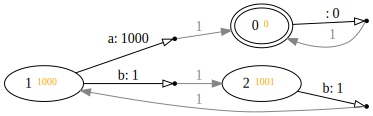

In [3]:
m.show("M")

## Bound of $|S|$ iteration is also incorrect when used for least fixed_point that computes survival levels

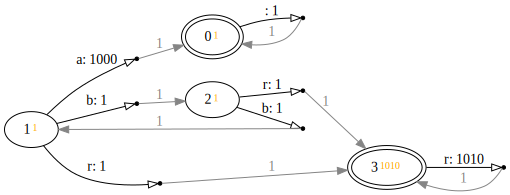

In [4]:
m = consMDP.ConsMDP()
m.new_state(True)
m.new_states(2)
m.new_state(True)
m.add_action(0, {0:1}, "", 1)
m.add_action(1, {0:1}, "a", 1000)
m.add_action(1, {2:1}, "b", 1)
m.add_action(2, {1:1}, "b", 1)
m.add_action(3, {3:1}, "r", 1010)
m.add_action(1, {3:1}, "r", 1)
m.add_action(2, {3:1}, "r", 1)
m.show("M")

In [5]:
from fimdp.safety_bound_incorrect import minInitCons
MI = minInitCons(m, 1005)
MI.get_values()
MI.get_safe()

[1, 8, 9, inf]

The correct values are indicated in red at the figure below.

[0, 1000, 1001, inf]


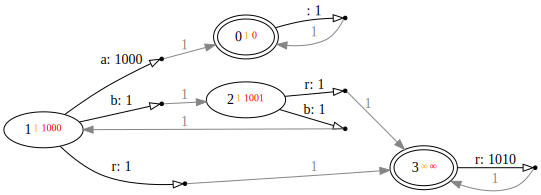

In [6]:
print(m.get_safe(1005))
m